# TP Python Master IBM/RPM
## 3ème partie : Analyse quantitative d'images TEP
Version de février 2022

### Albertine Dubois - <span class="glyphicon glyphicon-envelope"></span> albertine.dubois@cea.fr
----

In [1]:
!git clone https://github.com/marsvn/PythonM2-jour2.git

Cloning into 'PythonM2-jour2'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 40), reused 57 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 10.12 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
!pip install SimpleITK
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!unzip /content/drive/MyDrive/data.zip -d /content

Mounted at /content/drive
Archive:  /content/drive/MyDrive/data.zip
   creating: /content/data/
  inflating: /content/data/1-PT.nii  
  inflating: /content/data/2d-array.png  
  inflating: /content/data/3d-array-stack.png  
  inflating: /content/data/3d-array.png  
  inflating: /content/data/CT-Thorax.mhd  
  inflating: /content/data/CT-Thorax.raw  
  inflating: /content/data/CT.dcm    
  inflating: /content/data/CT.nii    
  inflating: /content/data/dicom2.png  
  inflating: /content/data/dicomstructure.jpg  
  inflating: /content/data/dicomstructure.png  
  inflating: /content/data/ImageOriginAndSpacing.png  
  inflating: /content/data/MRI.jpg   
   creating: /content/data/patient2/
  inflating: /content/data/patient2/Patient2.CT._.4.1.2019.11.21.11.52.34.596.71223801.dcm  
  inflating: /content/data/patient2/Patient2.CT._.4.10.2019.11.21.11.52.34.596.71223900.dcm  
  inflating: /content/data/patient2/Patient2.CT._.4.100.2019.11.21.11.52.34.596.71224890.dcm  
  inflating: /content/da

## 1. Rappels sur le SUV (Standardized uptake value)

La valeur de fixation normalisée (SUV en anglais pour Standardized Uptake Value) est l'index semi-quantitatif le plus communément utilisé en routine clinique pour caractériser la fixation du FDG en TEP.

Dans  sa  définition  la  plus  classique,  le  SUV  se  calcule comme   le   rapport   de   la   concentration moyenne du radiotraceur dans   un   tissu   d’intérêt (en Bq/mL) à un instant donné à l'activité totale injectée au patient (en Bq), rapporté à son volume (en mL). En supposant que le patient a une masse volumique de 1 g/mL, la valeur du volume en mL est la même que celle de la masse en grammes.

Le SUV est calculé en pratique en rapportant l'activité injectée au poids du patient.

$$ SUV_{BW}=\frac{[^{18}F-FDG]}{\frac{A_{inj}(t_{acq})}{W}} $$

Bien sûr, il faut tenir compte dans la formule ci-dessus du délai de temps $\Delta t$ entre l'injection et l'acquisition.

$$ A_{inj_{c}}=A_{inj}(t_{acq})\times 2^{(\frac{-\Delta t}{T_{1/2}})} $$

Le SUV est donc une quantité sans dimension, dont l’usage fréquent est en particulier dû à la simplicité de sa méthode de calcul.
* Si le radiotraceur se répartissait uniformément dans tout l’organisme,   le   SUV   serait   identique   en   tout   point   de l’organisme  et  égal  à 1.Tout  écart  du  SUV à 1  traduit  une répartition non uniforme du radiotraceur dans le volume dans lequel il s’est distribué.
* Le pouvoir de normalisation du SUV facilite l’interprétation   semi-quantitative   des   images.   En   effet,   même   si   la normalisation sous-jacente au calcul du SUV est grossière, elle est   tout   de   même   largement   préférable   à l’absence   de normalisation.  
* L’expression  des  images  en  échelle  SUV  rend comparables des images acquises chez différents patients, et des images acquises chez un patient à différents stades de la prise en charge thérapeutique.
* La normalisation n’est certes pas parfaite mais elle réduit tout de même considérablement la variabilité inter-patients et inter-examens.  
* Le SUV reste donc un index simpliste pour caractériser le métabolisme du glucose.

NB. Cette formule suppose que les images TEP ont été préalablement calibrées (conversion des valeurs d'intensité en activité). On peut le vérifier à partir de l'attribut `Units`. Dans le cas contraire, il faudrait ajouter une conversion supplémentaire :

$PET_{activity} = PET_{raw} \times rescale\_ slope + rescale\_intercept$

$rescale\_ slope$ et $rescale\_intercept$ sont deux attributs DICOM accessibles (numéro (0028,1052) et (0028,1053) respectivement).

In [6]:
# Import required packages
import numpy as np
import sys, os, subprocess
import matplotlib.pyplot as plt

# Import SimpleITK
import SimpleITK as sitk

# Import Pydicom
import pydicom

# Define current working directory
pwd_dir = '.'
# Define target directory
data_dir = os.path.join(pwd_dir,'data')

# Define target directory
target_dir = os.path.join(pwd_dir,'output')
# If it doesn't exist, create it
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

## 2. Lecture de l'image TEP `1-PT.nii` préalablement enregistrée au format Nifti

In [7]:
# On peut désormais directement travailler avec le volume TEP préalablement enregistré au format Nifti
IMAGE = sitk.ReadImage(os.path.join(data_dir,'1-PT.nii'))

## 3. Calcul du facteur de conversion TEP en unités SUV

Pour calculer le facteur de conversion de ces images TEP en unités SUV, il est nécessaire d'accéder aux valeurs des certains attributs DICOM.
* `Series Time`: Time the series started. Series Date and Series Time are used as the reference time for all PET Image Attributes that are temporally related, including activity measurements.
* `Radiopharmaceutical Start Time`: Time of start of administration. The actual time of radiopharmaceutical administration to the patient for imaging purposes, using the same time base as Series Time. Example: "070907.0705" represents a time of 7 hours, 9 minutes and 7.0705 seconds.
* `Radionuclide Total Dose`: The radiopharmaceutical dose administered to the patient measured in Becquerels (Bq) at the Radiopharmaceutical Start Time.
* `Radionuclide Half Life`: The radionuclide half life, in seconds, to be used in the correction of this image.
* `Patient's Weight`: Weight of the Patient, in kilograms.

Le site internet https://dicom.innolitics.com/ciods/pet-image regroupe l'ensemble des attributs DICOM relatif à la modalité d'imagerie TEP et renseigne les valeurs de tag number correspondants.

Il est parfaitement possible d'y accéder de manière automatique avec Python et sa librairie `pydicom` mais ce n'est pas l'objet ici (cf. cours de Ludovic Ferrer). C'est pourquoi la valeur de ces attributs vous est directement donnée.

In [8]:
# Valeurs des champs DICOM extraits des fichiers .dcm correspondants à l'image TEP
RST = 52244          # RadiopharmaceuticalStartTime [sec]
ST = 55477           # SeriesTime [sec]
RTD =  268000000     # RadionuclideTotalDose [Bq]
RHL = 6586.2         # RadionuclideHalfLife [s]
PW  = 90             # PatientWeight [kg]

CD = RTD * pow(2,- (ST - RST) / RHL )      # CorrectedDose (activitée injectée et corrigée de la décroissance radioactive au temps de l'acquisition)
PET_SUV_ScaleFactor = PET_SUV_ScaleFactor = PW * 1000 / CD

print("Valeur du facteur de conversion TEP en unités SUV =", PET_SUV_ScaleFactor)

# Sauvegarde de l'image TEP après conversion en unités SUV
sitk.WriteImage(IMAGE*PET_SUV_ScaleFactor, os.path.join(target_dir,'1-PT_SUV.nii'))
print('Image TEP en unités SUV enregistrée')

Valeur du facteur de conversion TEP en unités SUV = 0.0004719280293222231
Image TEP en unités SUV enregistrée


## 4. Calcul du facteur de conversion vox<->mm<sup>3</sup>

In [9]:
# Calcul de la taille du voxel permettant la conversion vox<->mm<sup>3</sup>

print('Taille du pixel (mm) : :', [IMAGE.GetSpacing()[0],IMAGE.GetSpacing()[1]])
print('Epaisseur de coupe (mm) :', IMAGE.GetSpacing()[2])

# Calcul du volume (en mm3) du voxel directement
vox2vol_Factor = IMAGE.GetSpacing()[0] * IMAGE.GetSpacing()[1] * IMAGE.GetSpacing()[2]

print("Facteur de conversion voxel<->mm3 = " + str(vox2vol_Factor) + " (mm3/voxel)")

Taille du pixel (mm) : : [4.0728302001953125, 4.0728302001953125]
Epaisseur de coupe (mm) : 2.027008056640625
Facteur de conversion voxel<->mm3 = 33.623899860034136 (mm3/voxel)


## 4. Ouvrir le volume TEP avec ITK-SNAP et trouver manuellement la coupe passant par la tumeur pulmonaire pour vérifier la cohérence entre les valeurs d'intensité des pixels

On commence par récupérer la valeur de l'intensité d'un voxel pris au hasard puis on la compare à celle donnée par ITK-SNAP.

Essayons avec le voxel de coordonnées **(89,131,329)**.<br>
**<span style='color:red'>Attention, les index commencent à zéro dans Python mais ... à 1 dans ITK-SNAP</span>** (il faudra donc mettre les valeurs (90,132,330) pour 'cursor position').

On trouve pour ce voxel 5892 Bq/mL dans ITK-SNAP

In [10]:
print('Intensité du pixel :', IMAGE[89,131,329])

Intensité du pixel : 5891.86032


## 5. Rogner (crop) le volume TEP à +/- 10 coupes dans chaque direction (pour ne pas etre gêné par l'activité cardiaque qui est intense chez ce patient)

On choisit le voxel de coordonnées **(90,130,337)** comme centre de la tumeur.

En réalité, on ne va pas réellement "rogner" le volume, mais on va mettre à 0 toutes les valeurs en dehors de cette "boite englobante" définie autour de la tumeur (ce qui permettra de faire un masque de la tumeur par la suite)

(-0.5, 199.5, 199.5, -0.5)

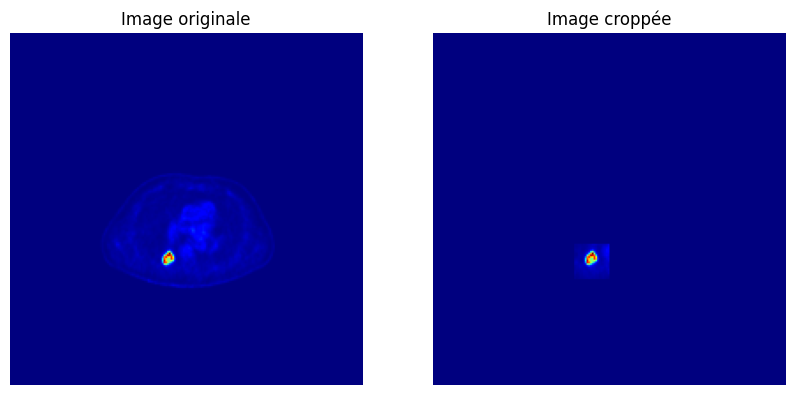

In [11]:
tumor_center = [90,130,337] # Définition du centre de la tumeur
nb_slices_to_crop = 10      # Demi-taille de la boîte englobante
TC , NS = tumor_center, nb_slices_to_crop
# Pour faciliter la lecture des lignes suivantes, on crée un nouveau volume 'croped'
IMAGE_cropped = IMAGE   # Sur la base du volume TEP initial
IMAGE_cropped_np = sitk.GetArrayFromImage(IMAGE_cropped)  # Copie du volume TEP initial

# On va mettre à 0 ce qui est en dehors de notre boîte englobante
# Attention à l'indexation des arrays NumPy dont l'ordre est inversé par rapport à l'image SimpleITK de départ
IMAGE_cropped_np[:,:,TC[0] + NS:] = 0
IMAGE_cropped_np[:,:,:TC[0] - NS] = 0

IMAGE_cropped_np[:,TC[1] + NS:,:] = 0
IMAGE_cropped_np[:,:TC[1] - NS,:] = 0

IMAGE_cropped_np[TC[2] + NS:,:,:] = 0
IMAGE_cropped_np[:TC[2] - NS,:,:] = 0

plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(IMAGE)[TC[2],:,:],cmap='jet')
plt.title('Image originale')
plt.axis('off')
plt.subplot(122)
plt.imshow(IMAGE_cropped_np[TC[2],:,:],cmap='jet')
plt.title('Image croppée')
plt.axis('off')

## 6. Récupération de la valeur du pixel d'intensité maximale en Bq/mL et conversion en unités SUV

In [12]:
total_flag = False     # Sélectionne si on travaillera sur le volume TEP entier (total_flag=True)
                       # ou si on travaillera sur le volume rogné (total_flag=False)

if total_flag:
    print("Mesures obtenues en utilisant tout le volume TEP")
    IMAGE_np = sitk.GetArrayFromImage(IMAGE)
else:
    print("Mesures obtenues en utilisant le volume TEP rogné (cropped)")
    IMAGE_np = IMAGE_cropped_np

IMAGE_np_max = IMAGE_np.max()
print("Valeur d'intensité maximale : " + str(IMAGE_np_max) + " Bq/mL")
print("Vérifier cette valeur en ouvrant le volume 1-PT.nii dans ITK-SNAP")
print("En utilisant l'inspecteur (menu Tools>Image Contrast>Contrast Adjustement...  ")
print("ou [Ctrl]+[I] puis l'onglet contraste qui donne la valeur maximale (en Bq/mL)")
# Conversion Bq/mL<->SUV

IMAGE_np_max_SUV = IMAGE_np_max * PET_SUV_ScaleFactor
print("Voxel le + intense : " + str(IMAGE_np_max) + " Bq/mL <=> " + \
      str(IMAGE_np_max_SUV) + " SUVmax")

Mesures obtenues en utilisant le volume TEP rogné (cropped)
Valeur d'intensité maximale : 61027.0224 Bq/mL
Vérifier cette valeur en ouvrant le volume 1-PT.nii dans ITK-SNAP
En utilisant l'inspecteur (menu Tools>Image Contrast>Contrast Adjustement...  
ou [Ctrl]+[I] puis l'onglet contraste qui donne la valeur maximale (en Bq/mL)
Voxel le + intense : 61027.0224 Bq/mL <=> 28.800362416635163 SUVmax


## 7. Seuillage de l'image à 15 ou 40% de cette valeur max et sauvegarde du masque binaire obtenu

Valeur max   :  61027.0224  Bq/mL
Valeur seuil :  9154.05336 Bq/mL  <=>  4.3200543624952745  SUV
Fichier SEG.nii écrit.. OK
Essayer d'autres seuils de segmentation [0;1] (0,40 est très sélectif, tenter 0,15 pour le volume rogne et 0,05 pour le volume entier)
Essayer sur l'image TEP entiere et sur l'image rognée (étape 6 mettre total_flag = False)
Ne pas oublier dans le quart inferieur gauche d'ITK-SNAP de cliquer sur 'update' pour visualiser
la segmentation en 3D


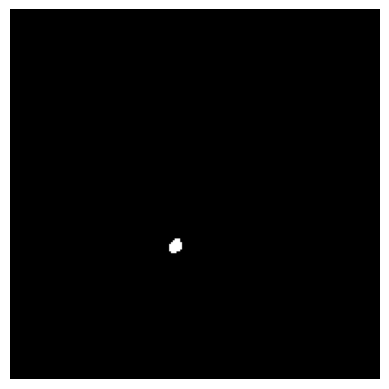

In [13]:
seuil = 0.15

IMAGE_np_seuil = seuil * IMAGE_np.max()    # Calcul du seuil relatif pour cette image
SEG_size = IMAGE.GetSize()                 # Récupère la taille de l'image, ce sera la taille de l'image segmentation
SEG = sitk.Image(SEG_size,sitk.sitkUInt8)  # Crée une image segmentation (masque binaire) 8 bits suffisent
SEG.CopyInformation(IMAGE)                 # Copie pixel_size, spacing , etc

SEG_mask = IMAGE_np >= IMAGE_np_seuil  # Masque qui correspond a notre condition de segmentation
plt.imshow(SEG_mask[TC[2],:,:],cmap='gray')
plt.axis('off')
print("Valeur max   : ",IMAGE_np.max()," Bq/mL")
print("Valeur seuil : ",IMAGE_np_seuil, "Bq/mL ",end = "")
print(" <=> ",IMAGE_np_seuil * PET_SUV_ScaleFactor," SUV")

# Créer l'objet sitk de segmentation a partir du masque (que l'on multiplie a une matrice de 'ones')
SEG = sitk.GetImageFromArray(np.multiply(SEG_mask,np.ones(SEG_mask.shape)))
# Sauvegarder la segmentation dans un fichier SEG.nii
sitk.WriteImage(SEG,os.path.join(target_dir,"SEG.nii"))
print("Fichier SEG.nii écrit.. OK")

print("Essayer d'autres seuils de segmentation [0;1] (0,40 est très sélectif, tenter 0,15 pour le volume rogne et 0,05 pour le volume entier)")
print("Essayer sur l'image TEP entiere et sur l'image rognée (étape 6 mettre total_flag = False)")
print("Ne pas oublier dans le quart inferieur gauche d'ITK-SNAP de cliquer sur 'update' pour visualiser")
print("la segmentation en 3D")


In [18]:
!apt-get -y install itksnap

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package itksnap is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'itksnap' has no installation candidate


In [16]:
#import subprocess
subprocess.call('/usr/local/itksnap-3.8.0-20190612-Linux-gcc64/bin/itksnap -g ' + os.path.join(data_dir,"1-PT.nii" + " -s " + \
                                           os.path.join(target_dir,"SEG.nii")),shell=True)

127

## 8. Calcul du volume tumoral correspondant

#### On fait le calcul en nombre de voxels puis en mm3

In [14]:
seg_nb_vox = len(SEG_mask[SEG_mask==1])
seg_nb_mm3 = seg_nb_vox * vox2vol_Factor
print("Seuil :",str(int(100*seuil))+" %")
print(seg_nb_vox,"voxels de segmentation /",len(SEG),"voxels")
print(str(seg_nb_vox) + " voxels <=> " + str(seg_nb_mm3) + " mm3")
print("Comparer ces valeurs (en voxels et en mm3)")
print("aux valeurs donnees dans ITK-SNAP (menu Segmentation>Volumes and Statistics...)")

Seuil : 15 %
601 voxels de segmentation / 21720000 voxels
601 voxels <=> 20207.963815880517 mm3
Comparer ces valeurs (en voxels et en mm3)
aux valeurs donnees dans ITK-SNAP (menu Segmentation>Volumes and Statistics...)


## 9. Evaluation de la charge métabolique

#### On utilise la somme cumulée des valeurs des voxels du volume segmenté

In [15]:
seg_cumsum = IMAGE_np[IMAGE_np >= IMAGE_np_seuil].cumsum()[-1]
print("Total cumulé    = " , seg_cumsum)
print("Moyenne         = " , seg_cumsum/seg_nb_vox)
print("Comparer cette valeur moyenne a la valeur donnée dans ITK-SNAP(menu Segmentation>Volumes and Statistics...)")

Total cumulé    =  14206997.107199991
Moyenne         =  23638.930294841914
Comparer cette valeur moyenne a la valeur donnée dans ITK-SNAP(menu Segmentation>Volumes and Statistics...)
